$\textbf{To begin: A simple model for single sodium channels}$:


In [209]:
import numpy as np
import matplotlib.pyplot as plt

In [513]:
#Euler method for solving ODEs:

def euler(f_func, x_0, t_max, dt):
    
    x = x_0
    nsteps = int(t_max / dt)
    xs = np.zeros(nsteps)
    xs[0] = x_0
    i = 1
    t = 0
    
    while i < nsteps:
        
        x = x + f_func(x,t)*dt
        xs[i] = x
        t += dt
        i += 1
    
    return xs

#Importing the gating dynamics of the sodium channel:

def alpha (V):
    
    return .01 * (V + 55) / (1 - np.exp(-.1 * (V + 55)))

def beta (V):

    return .125 * np.exp(-.0125 * (V + 65))

#Solving ODEs for gating dynamics:

dn = lambda n, t, V: alpha(V) * (1 - n) - beta(V) * n
n = lambda V: euler(lambda n, t: dn(n,t, V), .3177, 25, .1)

#Import Hodgkin-Huxley model code from previous worksheet:

def IK(V, gk = 36, Ek = -77):
    
    return gk * np.power(n(V),4) * (V - Ek)

In [ ]:
class Ion_channel:
    
    """
    Subsumes ion channels of different kinds
    @attributes:
    numGates: Total number of gates – global attribute
    numOpen: Number of open gates
    state: state of channel, open or closed
    
    This is a very simplified model. Later, for better modelling accuracy,
    it might be necessary to model each channel gate individually
    """
    
    def __init__(self, numOpen):
        
        numGates = 4
        self.numOpen = numOpen
        self.numGates = numGates
        self.state = "Open" if numOpen == self.numGates else "Closed"
        
    #Getter/Setter methods:
    
    def get_open_channels(self):
        return self.numOpen
        
    def set_open_channels(self, x):
        self.numOpen = x
        
    #Simulate opening/closing of single channel gate:
        
    def open_gate(self):
        
        self.numOpen += 1 if self.numOpen != 4 else 0
        
        if self.numOpen == 4:
            self.state = "Open"
        
    def close_gate(self):
        
        if self.numOpen == 4:
            self.state = "Closed"
        
        self.numOpen -= 1 if self.numOpen != 0 else 0 
        
        
    #Simulate voltage-voltage dependent channel state transitions:
    
    def change_state(self,V):
        
        
        """
        determines the channel's voltage dependent state transitions,
        according to the simple state diagramm 5.12 from Dayan&Abbott.
        @params:
        self: the channel under consideration
        V: the voltage across the membrane
        """
        
        k = self.get_open_channels()
        kMinus = 4 - k
        randNum = np.random.uniform(0,1)
        
        if randNum > 1 - kMinus * alpha(V):
            
            self.open_gate()
            
        if randNum < k * beta(V):
            
            self.close_gate()
        
        return self

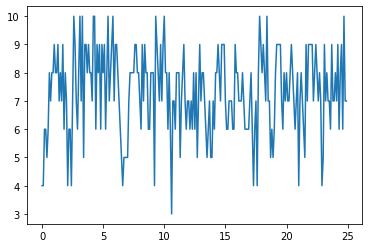

In [514]:
def simulate_channel (V, time = 25, dt = .1):
    
    gates = np.array([None for i in range (int(time / dt))])
    i = 0 
    
    #Initialize channel with random gate configuration:
    
    chan = Ion_channel(np.random.choice([0,1,2,3,4]))
    
    while i < len(gates):
        
        chan = chan.change_state(V)
        gates[i] = chan.numOpen
        
        i += 1 
        
    gates = np.where(gates >= 4, 1, 0)
        
    return gates


def simulate_multiple_channels (numChans, V, time = 25, dt = .1):
    
    acc = np.zeros(int(time / dt))
    
    for i in range(numChans):
    
        acc = acc + simulate_channel(V)
    
    return acc

test = simulate_multiple_channels(10, 10)

plt.plot(np.arange(0,25, .1), test) 

Now, in order to begin modelling we'll have to assume some value for a single channel's conductance $\gamma$. According to Koch this is usually somewhere north of $1pS$. We thus assume 1.5 $pS$. The conductance of a membrane is calculated simply as the product of single-channel conductance and number of open channels.

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1
 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0
 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0
 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0]


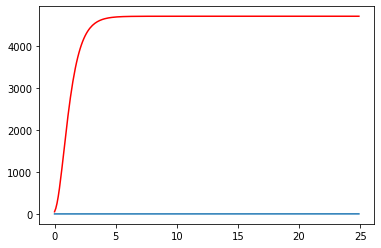

In [532]:
#Finally, to get the current we simply use the formula from the formula
#given by dayan and Abbott:

def potassium_current (V, chCondu, multiple, numChans, Ek = -77, gk = gk):
    
    """
    Calculates potassium current for simulated potassium channels
    @params:
    V: voltage in mV
    chCondu: the single channel conductance
    multiple: are multiple channles simulated?
    numChans: In case of multiple channels: how many channels
    are simulated?
    """
    
    if not multiple:
        
        return simulate_channel(V) * gk * (V - Ek) 
    
    else:
        
        return simulate_multiple_channels(V, numChans) * gk * (V - Ek)
    
    
def potassium_clamp(time = 25, dt = .1, Vc = 10, Vh = - 100):
    
    """
    This is the experiment from 5.12 that has to be replicated:
    The voltage is held at -100mV initially. Then it is clamped
    to 10mV for 20 seconds, before it is again unclamped. We'll
    let the time at which the clamp starts be 2 seconds.
    """
    
    clampTime = 2
    unclampTime = 22
    
    
    Varr = np.zeros(int(time / dt))
    Varr[i] = Vh if i < (clampTime / dt) or i > (unclampTime / dt) else Vc
    
    chan = Ion_channel(np.random.choice([0,1,2,3,4]))
    res = np.zeros(len(Varr))
    
    for vI, V in np.ndenumerate(Varr):
        
        chan = chan.change_state(V)
        res[vI] = chan.numOpen
        
    res = np.where(res >= 4, 1, 0)
        
    return res

print(potassium_clamp())
        
    
plt.plot(np.arange(0,25, .1), potassium_clamp())

plt.plot(np.arange(0,25,.1), Ik(65), c = 'red')


In [461]:

a = np.array([1,2,3])
np.add(a, np.ones(3))

array([2., 3., 4.])

True
